In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from keras import layers
from keras.preprocessing import image
import os
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Preparation :-

In [ ]:
# 1. creating directories for storing training, testing and validation data in resp class_names subdirectories
# 2. prepare_data reads images, converts into suitable scale and flips them if needed (in case of training data) and saves them.
# 3. train_cnt == # training data points
# 4. val_cnt = # val_data data points (images)
# Rest will be testing data

os.makedirs('/content/drive/MyDrive/Colab Notebooks/DeepLearning/images/training/covid',exist_ok = True)
os.makedirs('/content/drive/MyDrive/Colab Notebooks/DeepLearning/images/training/normal',exist_ok = True)
os.makedirs('/content/drive/MyDrive/Colab Notebooks/DeepLearning/images/testing/covid',exist_ok = True)
os.makedirs('/content/drive/MyDrive/Colab Notebooks/DeepLearning/images/testing/normal',exist_ok = True)
os.makedirs('/content/drive/MyDrive/Colab Notebooks/DeepLearning/images/validation/covid',exist_ok = True)
os.makedirs('/content/drive/MyDrive/Colab Notebooks/DeepLearning/images/validation/normal',exist_ok = True)

def prepare_data(pre,des,train_cnt,val_cnt):
    for file in os.listdir(pre+'/images'):
        #print(pre+'images/'+file)
        image = cv2.resize(cv2.imread(pre+'images/'+file),(256,256))
        mask = cv2.resize(cv2.imread(pre+'/masks/'+file),(256,256))
        image *= mask
        
        if(train_cnt > 0) : 
            cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/DeepLearning/images/training/'+des+'/'+file,image)
            if(des == 'covid') : cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/DeepLearning/images/training/'+des+'/flipped_'+file,image[:,::-1,:])
            train_cnt -= 1
        elif (val_cnt > 0):
            cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/DeepLearning/images/validation/'+des+'/'+file,image)
            if(des == 'covid') : cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/DeepLearning/images/validation/'+des+'/flipped_'+file,image[:,::-1,:])
            val_cnt -= 1
        else:
            cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/DeepLearning/images/testing/'+des+'/'+file,image)
            if(des == 'covid') : cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/DeepLearning/images/testing/'+des+'/flipped_'+file,image[:,::-1,:])




               


In [ ]:
pre = '/content/drive/MyDrive/Colab Notebooks/DeepLearning'
train_cnt = len(os.listdir(pre+'/covid/images'))
val_cnt = train_cnt*(0.15)
train_cnt -= 2*val_cnt
prepare_data(pre+'/covid/','covid',train_cnt,val_cnt)

In [ ]:
pre = '/content/drive/MyDrive/Colab Notebooks/DeepLearning'
train_cnt = len(os.listdir(pre+'/Normal/images'))
val_cnt = train_cnt*(0.15)
train_cnt -= 2*val_cnt
#print(pre+'/Normal/images')
prepare_data(pre+'/Normal/','normal',train_cnt,val_cnt)

In [ ]:
# Printing Total size of covid & normal dataset resp.

print(len(os.listdir('/content/drive/MyDrive/Colab Notebooks/DeepLearning/images/training/covid')),len(os.listdir('/content/drive/MyDrive/Colab Notebooks/DeepLearning/images/training/normal')))
print(len(os.listdir('/content/drive/MyDrive/Colab Notebooks/DeepLearning/images/validation/covid')),len(os.listdir('/content/drive/MyDrive/Colab Notebooks/DeepLearning/images/validation/normal')))
print(len(os.listdir('/content/drive/MyDrive/Colab Notebooks/DeepLearning/images/testing/covid')),len(os.listdir('/content/drive/MyDrive/Colab Notebooks/DeepLearning/images/testing/normal')))

5064 1400
1088 300
7226 300


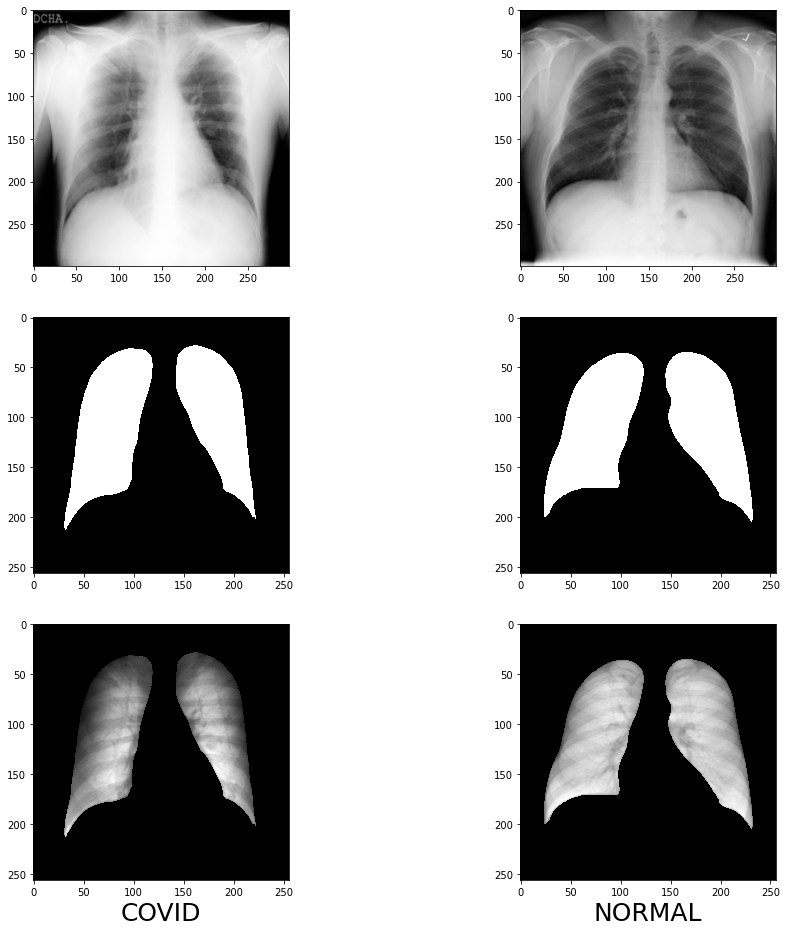

In [ ]:
covid = cv2.imread('/content/drive/MyDrive/Colab Notebooks/DeepLearning/covid/images/COVID-1000.png',cv2.IMREAD_GRAYSCALE)
covid_mask = cv2.imread('/content/drive/MyDrive/Colab Notebooks/DeepLearning/covid/masks/COVID-1000.png',cv2.IMREAD_GRAYSCALE)
covid1 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/DeepLearning/images/training/covid/COVID-1000.png',cv2.IMREAD_GRAYSCALE)

normal = cv2.imread('/content/drive/MyDrive/Colab Notebooks/DeepLearning/Normal/images/Normal-10.png',cv2.IMREAD_GRAYSCALE)
normal_mask = cv2.imread('/content/drive/MyDrive/Colab Notebooks/DeepLearning/Normal/masks/Normal-10.png',cv2.IMREAD_GRAYSCALE)
normal1 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/DeepLearning/images/training/normal/Normal-10.png',cv2.IMREAD_GRAYSCALE)

plt.figure(figsize = (16,16))
plt.subplot(3,2,1)
plt.imshow(covid,cmap = 'gray')
plt.subplot(3,2,2)
plt.imshow(normal,cmap = 'gray')
plt.subplot(3,2,3)
plt.imshow(covid_mask,cmap = 'gray')
plt.subplot(3,2,4)
plt.imshow(normal_mask,cmap = 'gray')
plt.subplot(3,2,5)
plt.imshow(covid1,cmap = 'gray')
plt.xlabel('COVID',fontdict = {'size':25})
plt.subplot(3,2,6)
plt.imshow(normal1,cmap = 'gray')
plt.xlabel('NORMAL',fontdict = {'size':25})
plt.show()

## Creating model :-

In [ ]:
# Building model 
# input shape (256,256,1) => cubic dimension, 2D image, 1 channels(1 unit - deapth)
# Model should be provided grayscale images

def build_model():
    input_layer = keras.Input(shape = (256,256,1)) 
    
    x = layers.Rescaling(1/255.)(input_layer)
    
    x = layers.Conv2D(64,(3,3),activation='relu',name = 'conv2d_2')(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.Dropout(0.5)(x)
    # randomly dropping some training points

    x = layers.Conv2D(128,(3,3),activation='relu',name = 'conv2d_3')(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Conv2D(256,(3,3),activation='relu',name = 'conv2d_4')(x)
    x = layers.MaxPooling2D(pool_size=(2,2))(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(32,activation='relu',name = 'dense_1')(x)
    x = layers.Dropout(0.5)(x)
    output_layer = layers.Dense(1,activation='sigmoid',name = 'dense_2')(x)

    return keras.Model(input_layer,output_layer,name = 'model')

In [ ]:
model = build_model()

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 1)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 254, 254, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 64)      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 128)     73856     
                                                             

In [ ]:
# creating data generators

train_gen = image.ImageDataGenerator()
train_ds = train_gen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/DeepLearning/images/training',
    target_size = (256,256),
    batch_size = 128,
    class_mode = 'binary',
    color_mode = 'grayscale'
)

val_gen = image.ImageDataGenerator()
val_ds = val_gen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/DeepLearning/images/validation',
    target_size = (256,256),
    batch_size = 128,
    class_mode = 'binary',
    color_mode = 'grayscale'
)

Found 6464 images belonging to 2 classes.
Found 1388 images belonging to 2 classes.


In [ ]:
model.compile(loss = 'binary_crossentropy',optimizer = 'Adam',metrics = ['accuracy'])

history = model.fit_generator(
    train_ds,
    validation_data = val_ds,
    epochs = 30,
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/30
51/51 [==============================] - 53s 804ms/step - loss: 0.6461 - accuracy: 0.7800 - val_loss: 0.3300 - val_accuracy: 0.7839
Epoch 2/30
51/51 [==============================] - 33s 650ms/step - loss: 0.3868 - accuracy: 0.8201 - val_loss: 0.2129 - val_accuracy: 0.9488
Epoch 3/30
51/51 [==============================] - 34s 654ms/step - loss: 0.3419 - accuracy: 0.8309 - val_loss: 0.1498 - val_accuracy: 0.9784
Epoch 4/30
51/51 [==============================] - 34s 652ms/step - loss: 0.3153 - accuracy: 0.8362 - val_loss: 0.1502 - val_accuracy: 0.9885
Epoch 5/30
51/51 [==============================] - 34s 651ms/step - loss: 0.3091 - accuracy: 0.8386 - val_loss: 0.1365 - val_accuracy: 0.9921
Epoch 6/30
51/51 [==============================] - 34s 656ms/step - loss: 0.2937 - accuracy: 0.8436 - val_loss: 0.1048 - val_accuracy: 0.9906
Epoch 7/30
51/51 [==============================] - 34s 661ms/step - loss: 0.2802 - accuracy: 0.8394 - val_loss: 0.0967 - val_accuracy: 0.9870

In [ ]:
import pickle
with open('nn_model_pickle','wb') as file:
    pickle.dump(model,file)

In [ ]:
with open('nn_model_pickle','rb') as file:
    model = pickle.load(file)

In [ ]:
train_ds.class_indices , val_ds.class_indices

({'covid': 0, 'normal': 1}, {'covid': 0, 'normal': 1})

In [ ]:
xtest = []
ytest = []

for file in os.listdir('/content/drive/MyDrive/Colab Notebooks/DeepLearning/images/testing/covid'):
    image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/DeepLearning/images/testing/covid/'+file,cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image,(256,256))
    xtest.append(image)
    ytest.append(0)
    
for file in os.listdir('/content/drive/MyDrive/Colab Notebooks/DeepLearning/images/testing/normal'):
    image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/DeepLearning/images/testing/normal/'+file,cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image,(256,256))
    xtest.append(image)
    ytest.append(1)
    
xtest = np.array(xtest)
ytest = np.array(ytest).reshape(-1,1)

In [ ]:
# predicting classes on xtest images and then
# sigmoid gives final output as close to 0 or 1 (not exactly 0 or 1)
# so converting them into 0 or 1 on the basis of closeness

ypred = (model.predict(xtest) > 0.5)*1

236/236 [==============================] - 11s 49ms/step


In [ ]:
# Finding accuracy on testing data

correct_pred = (ytest == ypred).sum()
print(100*correct_pred/(ytest.shape[0]))

97.1166622375764


### It can differentiate between a normal and a covid infected lung with 97% accuracy